### Import Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from collections import deque
import random

import matplotlib.dates as mdates
import seaborn as sns

### Download Data

In [82]:
from finrl import config_tickers
df = YahooDownloader(start_date = '2009-01-01',
                           end_date = '2022-09-30',
                           ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (101231, 8)


### Process Data

In [83]:
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=True,
                      user_defined_feature = False).preprocess_data(df.copy()).fillna(0)

Successfully added technical indicators
Successfully added turbulence index


In [84]:
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]
df = df.reset_index(drop=True)

In [85]:
df.sample(5)

date       close        high         low        open    volume  \
16424  2011-04-01   27.281256   37.869999   36.959999   37.119999   9247500   
95776  2022-02-14  114.945168  133.436462  129.899673  133.235779   5542742   
48554  2015-08-27   94.608871  102.620003   99.779999  101.349998  17532200   
32265  2013-06-05   71.105911   98.160004   96.120003   98.129997   5394800   
94584  2021-12-15  144.462128  159.850006  157.350006  159.850006  14014200   

       tic  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
16424   HD    4  0.125187   27.661967   25.840814  55.955097   62.790419   
95776  MMM    0 -3.166876  130.671421  112.431680  35.423327 -134.110107   
48554  DIS    3 -4.096178  113.332197   85.373281  40.786203  -90.481635   
32265  MCD    2 -0.551096   75.578244   71.078967  44.882584 -188.776958   
94584  JPM    2 -1.741407  152.916865  142.164867  44.919738 -102.225342   

           dx_30  close_30_sma  close_60_sma  turbulence  
16424   8.433525     26.821863     26.582129   28.168619  
95776  47.220542    124.462948    126.153916   19.356636  
48554  49.379688    103.008567    103.930970   42.829530  
32265  29.259820     73.712997     73.502251   23.222264  
94584  14.915668    149.512270    151.085852   36.274596

### Train-Test Split

In [86]:
train = data_split(df, '2009-01-01','2019-12-31')
trade = data_split(df, '2020-01-01','2022-09-30')

### Environment Setup

In [46]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension #stock, shares, technical indicators, 

In [47]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS,  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4,  # Scaling factor for rewards to normalize them and improve learning stability.
    "print_verbosity":5
}

### Custom Trading Environment

In [48]:
class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
            # Call the parent constructor
            super().__init__(df=df, **kwargs)
            self.action_space = spaces.Box(
            low=-self.hmax, 
            high=self.hmax, 
            shape=(self.stock_dim,), 
            dtype=np.float32
        )
    def save_state_memory(self):
        """Save state memory dynamically without hard-coded column names."""
        if len(self.df.tic.unique()) > 1:
            # Get the date memory (excluding the last one)
            date_list = self.date_memory[:-1]

            # Ensure state_list is not empty
            state_list = self.state_memory
            # print(len(state_list[0]))
            if not state_list:
                print("Warning: state_memory is empty!")
                return pd.DataFrame()  # Return an empty DataFrame if no data exists

            # Ensure each state has the same structure
            try:
                num_features = len(state_list[0])  # Get number of features from the first state
                state_columns = [f"feature_{i}" for i in range(num_features)]  # Generate feature names
            except IndexError:
                print("Error: state_memory contains empty entries.")
                return pd.DataFrame()  # Return an empty DataFrame if there's an issue

            df_date = pd.DataFrame(date_list, columns=["date"])
            df_states = pd.DataFrame(state_list, columns=state_columns)
            df_states.index = df_date["date"]  # Set index to match dates
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})

        return df_states
    # def step(self, action):
    #     # Clip actions to feasible shares based on current holdings
    #     # print(action)
    #     for i in range(self.stock_dim):
    #         current_shares = self.state[i * 2 + 1]
    #         action[i] = np.clip(action[i], -current_shares, self.hmax)
        
    #     return super().step(action)
    def step(self, action, state = None):
        # Clip actions to feasible shares based on current holdings
        if state is not None:
            self.state = state
        for i in range(self.stock_dim):
            current_shares = self.state[i * 2 + 1]
            action[i] = np.clip(action[i], -current_shares, self.hmax)
        
        return super().step(action)
    

### Multi-Layer Perceptron

In [49]:
class MetaPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hmax=100):
        """
        :param hmax: Maximum shares allowed (used for action scaling)
        """
        super().__init__()
        self.hmax = hmax
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Outputs in [-1, 1] for easy scaling
        )
    
    def forward(self, x):
        # Outputs in [-1, 1], scaled to [-hmax, hmax]
        return self.net(x) * self.hmax

### Define Meta Environment

In [50]:
meta_env_train_gym = CustomStockTradingEnv(df=train, **env_kwargs)
meta_env_train, obs = meta_env_train_gym.get_sb_env()
# print(obs)
num_stocks  = meta_env_train_gym.action_space.shape[0]
state_features_dim = meta_env_train_gym.state_space
num_base_models = 3
input_dim = num_base_models * num_stocks + state_features_dim
output_dim = num_stocks
hidden_dim = 64 

### Get Base Models

In [51]:
agent = DRLAgent(env = meta_env_train)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c", device='cpu')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWa

### Define Meta Model

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
meta_policy_model = MetaPolicy(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=1e-3)

In [54]:
# Initialize replay buffer with a maximum capacity (e.g., 10,000 transitions)
replay_buffer = deque(maxlen=10000)
batch_size = 64  # Number of transitions to sample per training step

### Training (Second Iteration)

In [55]:
def DRL_prediction(model, environment, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        # print(test_obs)
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states
        state_memory = None
        rewards_memory = []

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            next_obs, rewards, dones, info = test_env.step(action)
            rewards_memory.append(rewards)
            # state_memory.append(test_obs)
            test_obs = next_obs
            if (
                i == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
                state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break
        # state_columns = [f"feature_{i}" for i in range(len(state_memory[0][0]))]
        # state_memory = pd.DataFrame([i[0] for i in state_memory], columns=state_columns)
        return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)

In [56]:
ddpg_account_value, ddpg_actions, ddpg_states, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)

ppo_account_value, ppo_actions, ppo_states, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)

a2c_account_value, a2c_actions, a2c_states, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)

hit end!
hit end!
hit end!


In [57]:
decision_points = pd.concat([ddpg_states, ppo_states, a2c_states], axis=0)
decision_points.shape

(8298, 291)

#### Training Dataset

In [58]:
env = CustomStockTradingEnv(df=train, **env_kwargs)

In [59]:
dataset = []
for i in range(len(decision_points)):
    row = decision_points.iloc[i]
    state = row.values
    # print(state)
    action_best = None
    reward_best = -np.inf
    actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        actions.append(action)
        next_state, reward, done, info, _ = env.step(action, state)
        if reward > reward_best:
            reward_best = reward
            action_best = action
    input_vector = np.concatenate([np.concatenate(actions), state])
    dataset.append((input_vector, action_best))

# print(len(dataset))        
        
    
    
    

day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 2162882.59
total_reward: 1162882.59
total_cost: 49082.89
total_trades: 52487
Sharpe: 1.150
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 2162882.59
total_reward: 1162882.59
total_cost: 49082.89
total_trades: 52487
Sharpe: 1.150
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 2162882.59
total_reward: 1162882.59
total_cost: 49082.89
total_trades: 52487
Sharpe: 1.150
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 2182020.86
total_reward: 1182020.86
total_cost: 49082.89
total_trades: 52487
Sharpe: 1.150
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 2182020.86
total_reward: 1182020.86
total_cost: 49082.89
total_trades: 52487
Sharpe: 1.150
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 2182020.86
total_reward: 1182020.86
total_cost: 49082.89
total_trades: 52487
Sharpe: 1.150
day: 2766, episode: 0
begin_total_asset:

In [60]:
D = TensorDataset(torch.FloatTensor(np.array([i[0] for i in dataset])), torch.FloatTensor(np.array([i[1] for i in dataset])))
loader = DataLoader(D, batch_size=64, shuffle=True, pin_memory=True)

In [96]:
meta_policy_model = MetaPolicy(input_dim, 256, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=0.00001)

In [97]:
for episode in range(5000):
    episode_loss = 0
    for input, label in loader:
        optimizer.zero_grad()
        
        input_tensor = torch.FloatTensor(input).to(device)
        label_tensor = torch.FloatTensor(label).to(device)
        
        predicted_action = meta_policy_model(input_tensor)

        loss = criterion(predicted_action, label_tensor)
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    # break
    print(f"Episode {episode} | Loss: {episode_loss}")

Episode 0 | Loss: 1229936.5859375
Episode 1 | Loss: 1206573.1416015625
Episode 2 | Loss: 1185351.365234375
Episode 3 | Loss: 1170935.25390625
Episode 4 | Loss: 1159796.3505859375
Episode 5 | Loss: 1145753.720703125
Episode 6 | Loss: 1135224.984375
Episode 7 | Loss: 1126398.8818359375
Episode 8 | Loss: 1115634.0126953125
Episode 9 | Loss: 1107943.3125
Episode 10 | Loss: 1097778.3486328125
Episode 11 | Loss: 1085475.404296875
Episode 12 | Loss: 1076128.28125
Episode 13 | Loss: 1066997.3828125
Episode 14 | Loss: 1055377.8833007812
Episode 15 | Loss: 1047095.908203125
Episode 16 | Loss: 1039510.58203125
Episode 17 | Loss: 1030102.412109375
Episode 18 | Loss: 1021045.0107421875
Episode 19 | Loss: 1011732.591796875
Episode 20 | Loss: 999762.1108398438
Episode 21 | Loss: 994656.498046875
Episode 22 | Loss: 986664.5903320312
Episode 23 | Loss: 977945.4145507812
Episode 24 | Loss: 971527.1298828125
Episode 25 | Loss: 965963.6235351562
Episode 26 | Loss: 960150.0151367188
Episode 27 | Loss: 9543

##### Backtesting performance

In [98]:
meta_env_trade_gym = CustomStockTradingEnv(df=trade, **env_kwargs)
meta_env_trade, obs = meta_env_trade_gym.get_sb_env()
agent = DRLAgent(env = meta_env_trade)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c", device='cpu')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWa

In [99]:
env = CustomStockTradingEnv(df=trade, **env_kwargs)
state = env.reset()

# ===== Step 2: Trading Loop with Meta-Policy Model =====
done = False
ensemble_account_history = []

while not done:
    # Preprocess state
    state = np.array(state[0]).reshape(-1)
    
    # Collect actions from base DRL models
    base_actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        base_actions.append(action)
    base_actions = np.concatenate(base_actions).reshape(-1)
    
    # Create input vector for meta-policy model
    input_vector = np.concatenate([base_actions, state])
    input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
    
    # Predict final action using meta-policy model
    with torch.no_grad():
        predicted_action = meta_policy_model(input_tensor)
    action = predicted_action.cpu().numpy()[0]

    # Execute trade
    next_state, reward, done, info, _ = env.step(action)
    state = [next_state]

# Save and Display Ensemble Results
ensemble_account_history = env.save_asset_memory()
ensemble_results = pd.DataFrame(ensemble_account_history, columns=["date", "account_value"])


In [100]:
backtest_stats(ensemble_results, value_col_name="account_value")

Annual return         -0.006450
Cumulative returns    -0.017611
Annual volatility      0.321325
Sharpe ratio           0.139561
Calmar ratio          -0.015720
Stability              0.036830
Max drawdown          -0.410261
Omega ratio            1.026201
Sortino ratio          0.200287
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.896100
Daily value at risk   -0.040305
dtype: float64


Annual return         -0.006450
Cumulative returns    -0.017611
Annual volatility      0.321325
Sharpe ratio           0.139561
Calmar ratio          -0.015720
Stability              0.036830
Max drawdown          -0.410261
Omega ratio            1.026201
Sortino ratio          0.200287
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.896100
Daily value at risk   -0.040305
dtype: float64

In [101]:
def evaluate_model(model, model_name):
    """Run backtesting for an individual DRL model and return account history."""
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model=model,
        environment=env
    )
    backtest_stats(df_account_value)
    return df_account_value

In [102]:
# Evaluate DDPG
ddpg_results = evaluate_model(trained_ddpg, "DDPG")

# Evaluate PPO
ppo_results = evaluate_model(trained_ppo, "PPO")

# Evaluate A2C
a2c_results = evaluate_model(trained_a2c, "A2C")

hit end!
Annual return         -0.019279
Cumulative returns    -0.052054
Annual volatility      0.278717
Sharpe ratio           0.070993
Calmar ratio          -0.049550
Stability              0.361555
Max drawdown          -0.389087
Omega ratio            1.014300
Sortino ratio          0.095216
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.840027
Daily value at risk   -0.035036
dtype: float64
hit end!
Annual return         -0.004282
Cumulative returns    -0.011714
Annual volatility      0.260928
Sharpe ratio           0.114624
Calmar ratio          -0.011864
Stability              0.465198
Max drawdown          -0.360916
Omega ratio            1.022806
Sortino ratio          0.157270
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.875021
Daily value at risk   -0.032755
dtype: float64
hit end!
Annual return          0.058201
Cumulative returns     0.168061
Annual volatility      0.239351
Sharpe ratio   

In [103]:
df_dji = YahooDownloader(
    start_date='2020-01-01', end_date='2022-09-30', ticker_list=["dji"]
).fetch_data()
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (522, 8)


In [104]:
baseline_df = get_baseline(
    ticker="^DJI",
    start='2020-01-01',
    end='2022-09-30'
)
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (692, 8)
Annual return          0.004483
Cumulative returns     0.012360
Annual volatility      0.255501
Sharpe ratio           0.146104
Calmar ratio           0.012089
Stability              0.519778
Max drawdown          -0.370862
Omega ratio            1.030366
Sortino ratio          0.199469
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.858118
Daily value at risk   -0.032042
dtype: float64


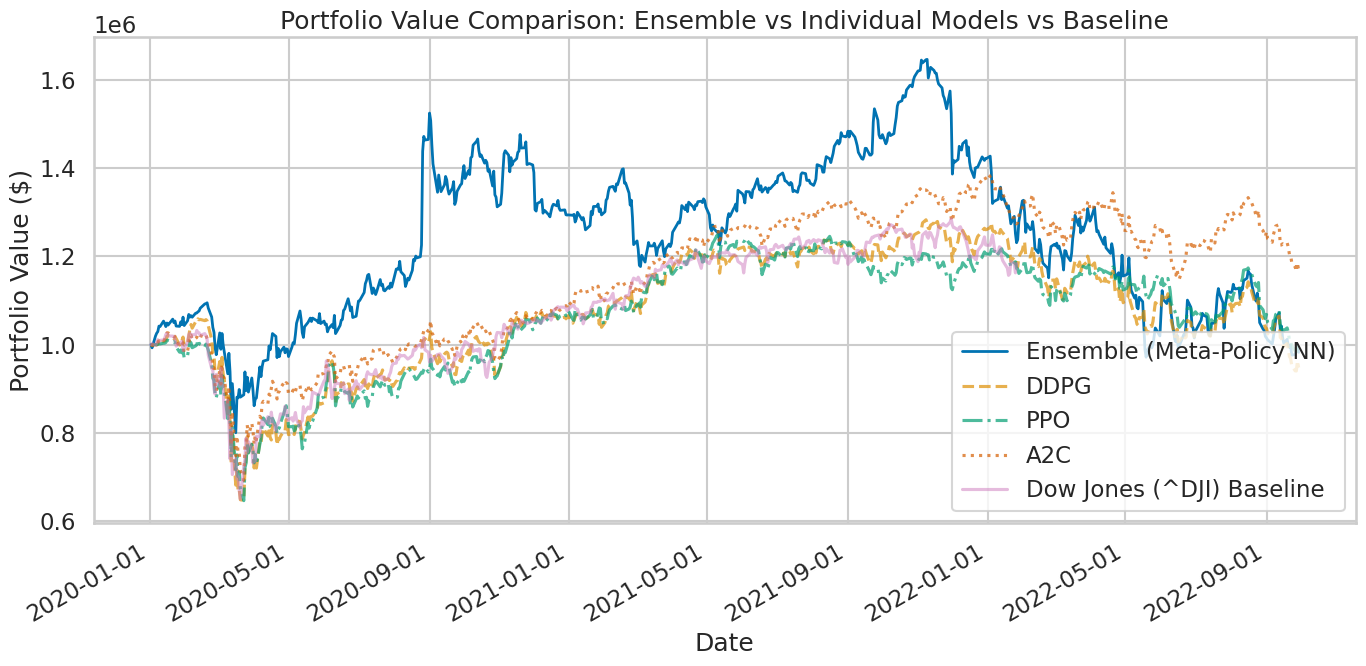

In [105]:
# Set a Seaborn theme for a cleaner look
sns.set_theme(style='whitegrid', context='talk')

# Optionally, define a Seaborn color palette
palette = sns.color_palette("colorblind", 5)

# Convert 'date' columns to datetime if they are not already
ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
ppo_results['date'] = pd.to_datetime(ppo_results['date'])
a2c_results['date'] = pd.to_datetime(a2c_results['date'])
dji['date'] = pd.to_datetime(baseline_df['date'])

# Create the figure
plt.figure(figsize=(14, 7))

# Plot each series using Seaborn's palette for consistency
plt.plot(ensemble_results['date'], ensemble_results['account_value'], 
         label='Ensemble (Meta-Policy NN)', linewidth=2, color=palette[0])
plt.plot(ddpg_results['date'], ddpg_results['account_value'], 
         label='DDPG', linestyle='--', alpha=0.7, color=palette[1])
plt.plot(ppo_results['date'], ppo_results['account_value'], 
         label='PPO', linestyle='-.', alpha=0.7, color=palette[2])
plt.plot(a2c_results['date'], a2c_results['account_value'], 
         label='A2C', linestyle=':', alpha=0.7, color=palette[3])
plt.plot(dji['date'], dji['close'], 
         label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[4])

# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add titles and labels
plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [38]:
plt.savefig("ensemble_vs_individual_models.png")

### Training (Third Iteration)